In [567]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
from pathlib import Path
from scipy.odr import *

In [568]:
def CalculateMeanandStd(T):
    T['meanADC'] = T['ADCSum']/T['samples']
    T['stdADC'] = np.sqrt((T['ADCSquareSum']-T['samples']*(T['meanADC']**2))/(T['samples']-1))
    return(T)

In [569]:
def find_saturation_from_derivate(T):
        
    T = T.sort_values(by=['meanADC'],ignore_index=True)
    # Extract x and y values
    x = T['meanRefPD'].values
    y = T['meanADC'].values

    # Compute the first derivative using central differences
    dy_dx = np.gradient(y, x)

    # Add the derivative to the DataFrame
    T['dy_dx'] = dy_dx
    
    # Define a threshold for identifying the plateau
    threshold = 0.001

    # Identify indices where dy_dx is not flat
    #non_flat_indices_aux = np.where(np.abs(dy_dx) >= threshold)[0]

    # Get some extra distance to be sure that there is a reduced number of flat indices
    #non_flat_indices = non_flat_indices_aux[:-5]

    
    flat_indices = np.nonzero(np.abs(dy_dx) < threshold)[0]
    flat_indices = flat_indices[np.nonzero(flat_indices > 10)[0]]
    if flat_indices.size > 0:
            # Find the index and shift it by two for safety
            first_flat_index = flat_indices[0] 
            satADC=y[first_flat_index]
            safe_index = first_flat_index -2
            T_non_flat = T.iloc[:safe_index]
    else:
            satADC=-1
            T_non_flat = T
    
    #print(satADC)
    # Extract the corresponding rows
    #T_non_flat = T.iloc[non_flat_indices]
    
    return T_non_flat, satADC

In [570]:
def ReadData(folderpath,PDID,wavelength):
    Ttotal = pd.DataFrame()
    for filename in os.listdir(folderpath):
        if  PDID in filename and wavelength in filename:
            #Read and store the data
            T = pd.read_csv(f'{folderpath}/{filename}',delimiter ='\t',header=None)
            T.columns = ['date-time', 'L', 'ADCSum', 'ADCSquareSum', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
            #T = CalculateMeanandStd(T)
            #T,sat = find_saturation_from_derivate(T)
            Ttotal = pd.concat([Ttotal,T],ignore_index=True)
            if 'FW1' in filename:
                FW = 'FW1'
            if 'FW4' in filename:
                FW = 'FW4'
    return Ttotal, FW
    

In [571]:
def PlotADC(T,PDID,wavelength,FW, intercept, slope,std):
    fig, ax = plt.subplots()
    ax.errorbar(T['meanADC'], T['meanRefPD'],  yerr=T['stdRefPD'], xerr=T['stdADC'], fmt='.', markersize=5, linewidth=1,zorder=1)
    ax.set_xlabel('Mean ADC (ADU)')
    ax.set_ylabel('Mean ref PD (V)')
    ax.grid()
    ax.set_title(f'TF for PD {PDID}, {wavelength}, {FW}')
    ax.plot(T['meanADC'], intercept + slope*T['meanADC'], 'r', label='fitted line', linewidth=1, alpha=0.7)
    ax.text(0.1,0.9,f'TF={slope:.5e} +/- {std:.1e} ',verticalalignment='top', bbox=dict(facecolor='white', alpha=1), transform=ax.transAxes)
    fig.savefig(f'./Output/TF for PD {PDID}, {wavelength}, {FW}.png',dpi=199)

   PDID Wavelength   FW        TF         TFstd        CC         CCstd  \
0   0.2        532  FW4  0.000330  1.933913e-07  0.000428  2.509358e-07   
1   0.3        532  FW4  0.000331  1.760282e-07  0.000428  2.509358e-07   
2   1.2        532  FW4  0.000328  1.736755e-07  0.000428  2.509358e-07   
3   1.3        532  FW4  0.000331  1.828265e-07  0.000428  2.509358e-07   
4   2.2        532  FW4  0.000329  1.918700e-07  0.000428  2.509358e-07   
5   2.3        532  FW4  0.000334  1.599206e-07  0.000428  2.509358e-07   
6   3.2        532  FW4  0.000332  1.819137e-07  0.000428  2.509358e-07   
7   3.3        532  FW4  0.000329  2.102567e-07  0.000428  2.509358e-07   
8   4.2        532  FW1  0.000348  1.957690e-07  0.000074  3.561506e-07   
9   4.3        532  FW1  0.000351  2.240472e-07  0.000074  3.561506e-07   
10  0.2       1064  FW4  0.000179  7.939470e-08  0.000346  7.143241e-08   
11  0.3       1064  FW4  0.000178  6.914716e-08  0.000346  7.143241e-08   
12  1.2       1064  FW4  

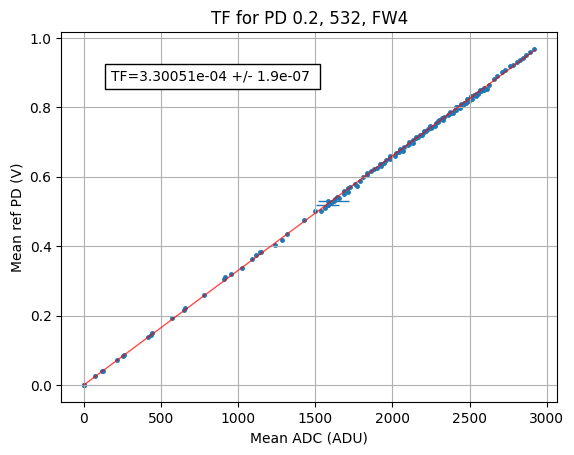

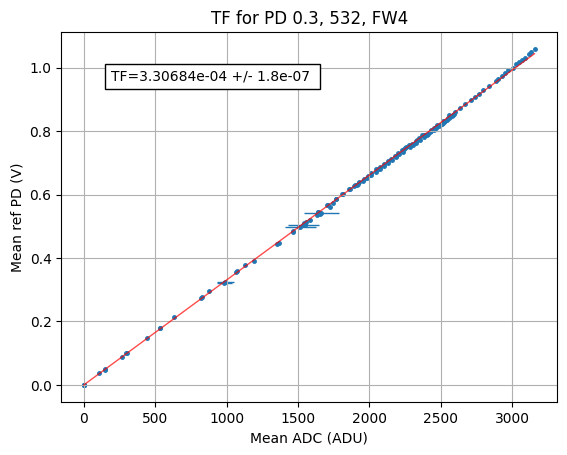

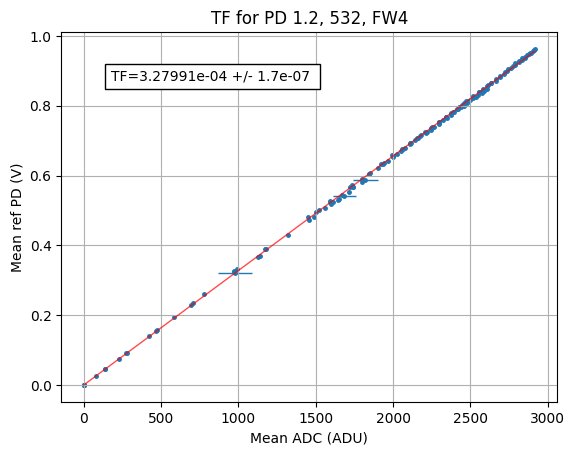

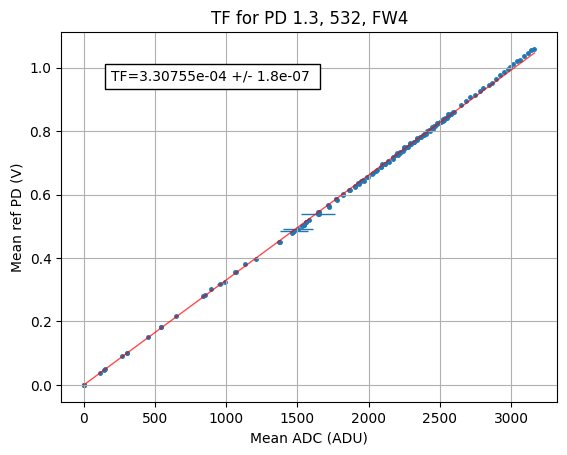

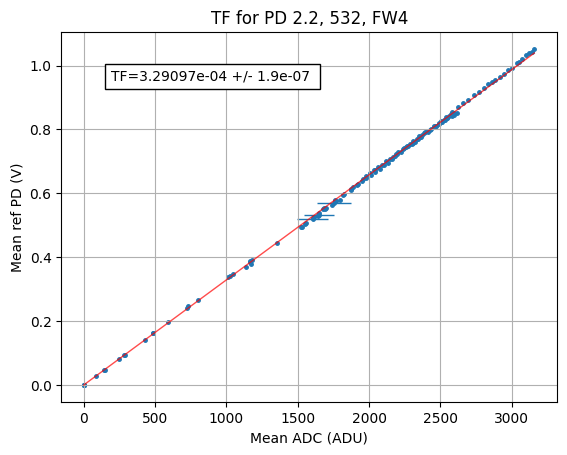

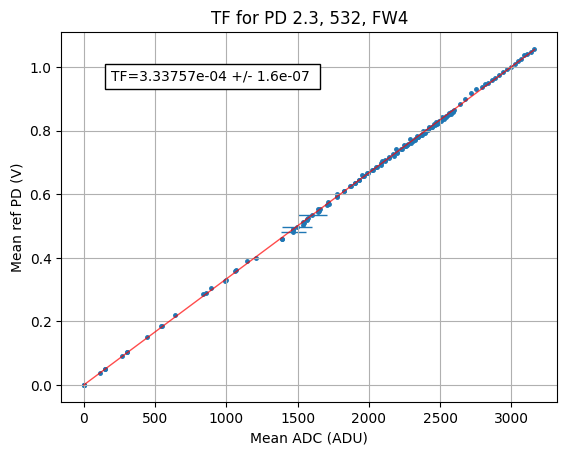

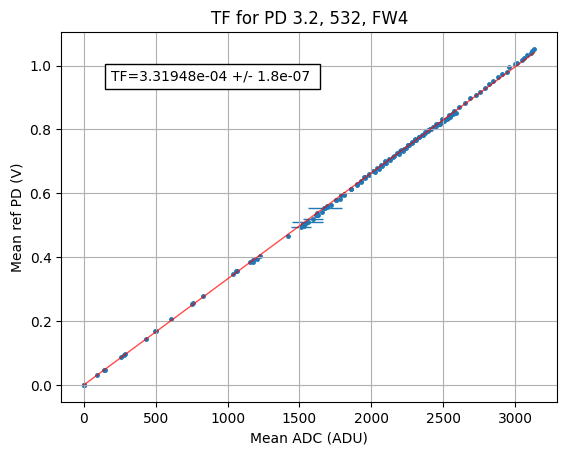

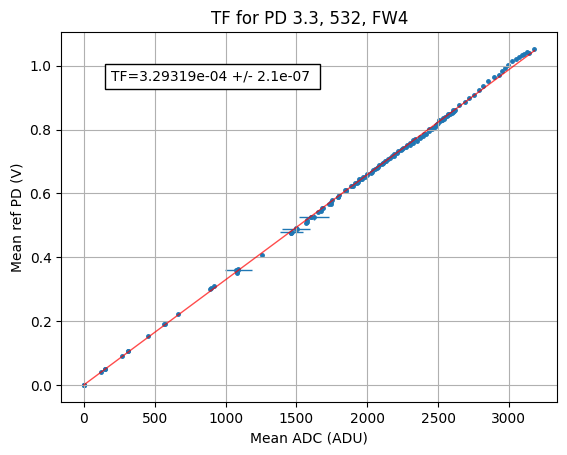

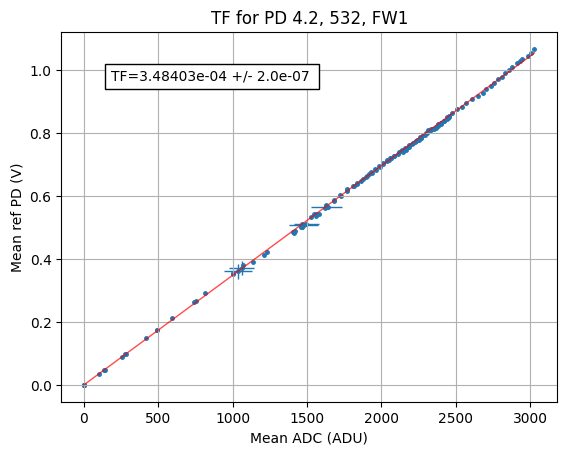

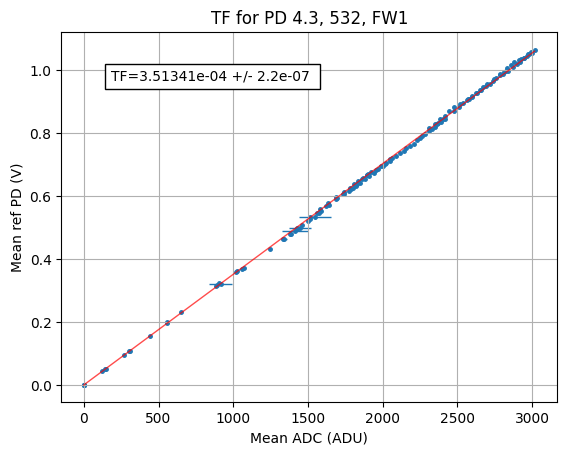

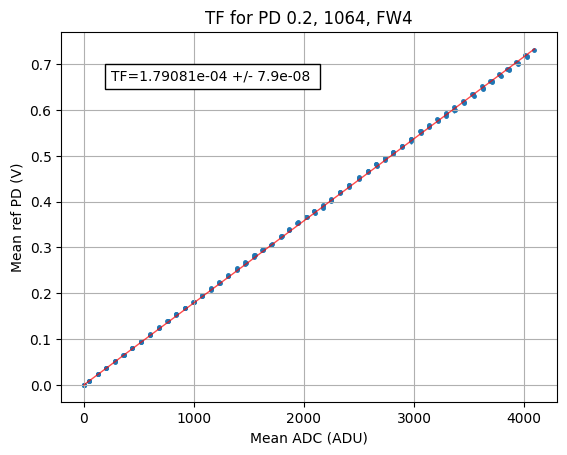

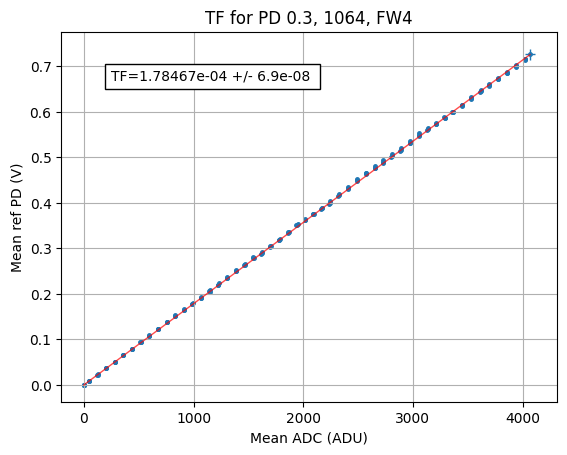

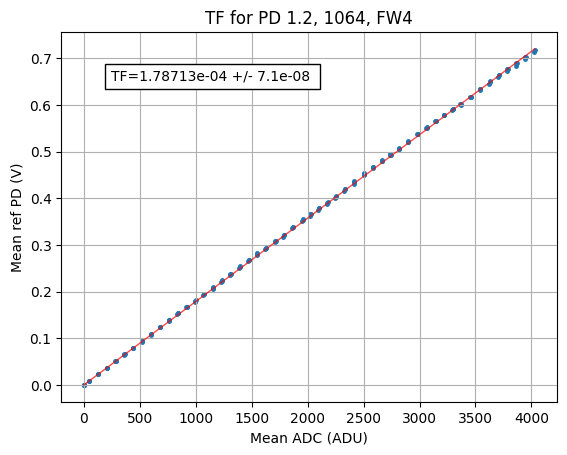

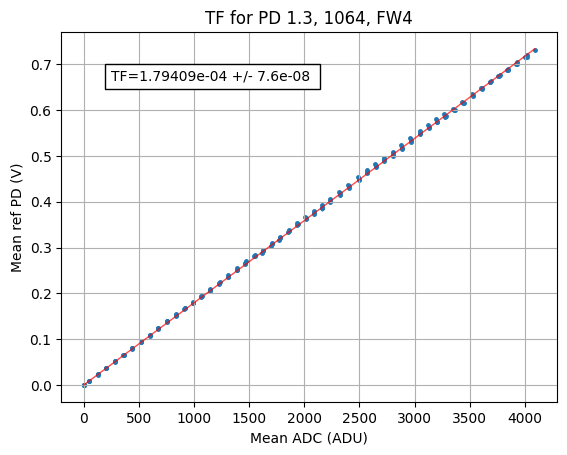

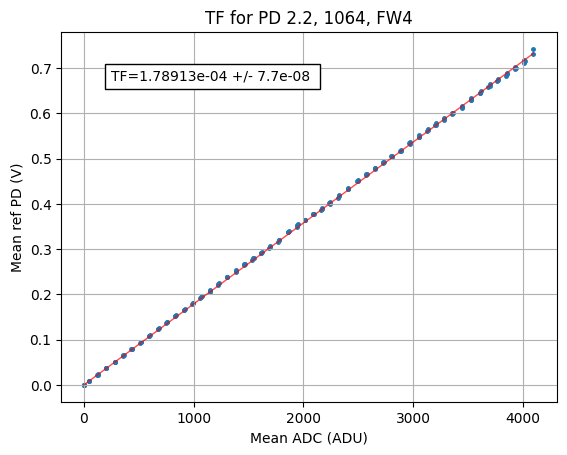

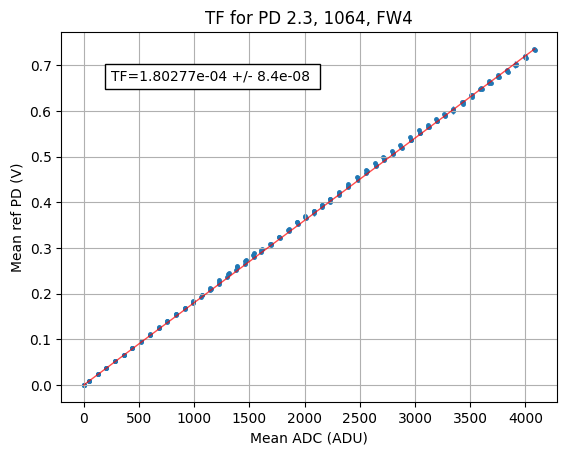

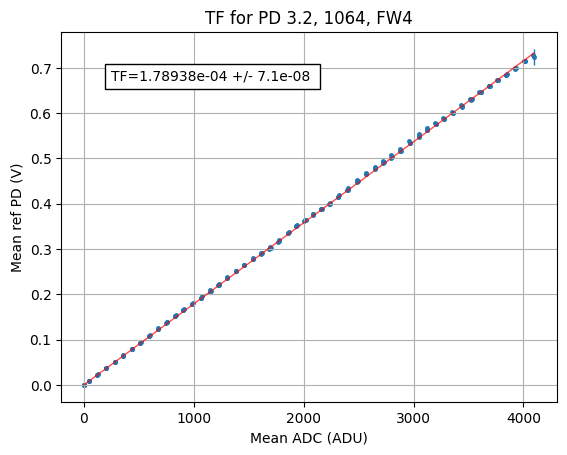

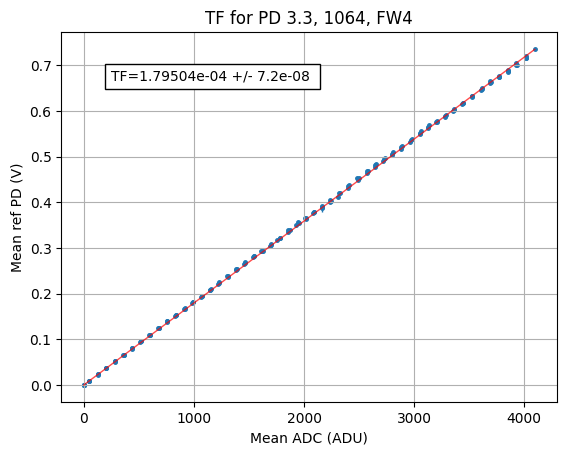

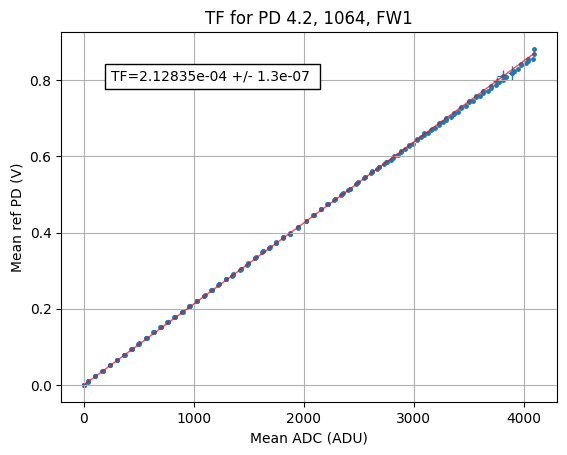

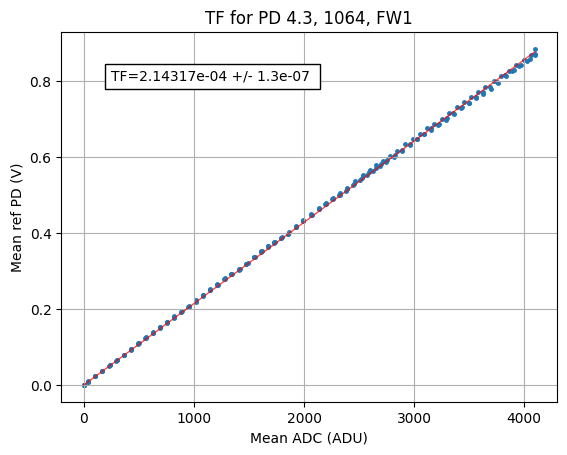

In [572]:
#Initialize lists
PDIDs = ["0.2","0.3","1.2","1.3","2.2","2.3","3.2","3.3","4.2","4.3"]
wavelengths = ["532","1064"]
Results = pd.DataFrame({'PDID':[],
                        'Wavelength':[],
                        'FW':[],
                        'TF':[],
                        'TFstd':[]})

#Initialize counter
i = 0

for wavelength in wavelengths:
    for PDID in PDIDs:
       #ReadData and calculate MeanADC and stdADC
       T , FW = ReadData('./20062025_1R0',PDID,wavelength,)
       T = CalculateMeanandStd(T)
       # Find saturation value and remove points above saturation value
       T,sat = find_saturation_from_derivate(T)
       #Remove zeroes in std
       T['stdADC'] +=  1e-10

       #Perform ODR
       def f(B, x):
            '''Linear function y = m*x + b'''
            # B is a vector of the parameters.
            # x is an array of the current x values.
            # x is in the same format as the x passed to Data or RealData.
            #
            # Return an array in the same format as y passed to Data or RealData.
            return B[0]*x + B[1]

       linear = Model(f)
       mydata = RealData(T['meanADC'], T['meanRefPD'], sx=T['stdADC'], sy=T['stdRefPD'])
       myodr = ODR(mydata, linear, beta0=[3.e-4, 0.])
       myoutput = myodr.run()
       meanTF = myoutput.beta[0]
       stdTF = myoutput.sd_beta[0]

       #Plot
       PlotADC(T,PDID,wavelength,FW,myoutput.beta[1],meanTF,stdTF)

       #Store the results
       Results.loc[i] = [PDID,wavelength,FW,meanTF,stdTF]
       i += 1

#Read results from setup 1
CC = pd.read_csv(f'./ResultsSetup1.csv', index_col=0)
CC['Wavelength'] = CC['Wavelength'].astype('string')

#Merge all reslults
FinalResults = pd.merge(Results,CC, how='left', on=['Wavelength','FW'])

#Calculate total CF and std of CF
FinalResults['CF'] = FinalResults['TF']*FinalResults['CC']
FinalResults['CFstd'] = np.sqrt((FinalResults['TFstd']*FinalResults['CC'])**2 + (FinalResults['CCstd']*FinalResults['TF'])**2)
FinalResults['CFRelSdt'] = FinalResults['CFstd']/FinalResults['CF']

FinalResults.to_csv('./Finalresults.csv')
print (FinalResults)